# <center> Telecom Paris Data Challenge

# <center> Data Challenge n°2 : Face images classification on unknown face features, IDEMIA dataset

  
    
    
### <center> by: Jerome Dauba

#<center> Rank : 3rd

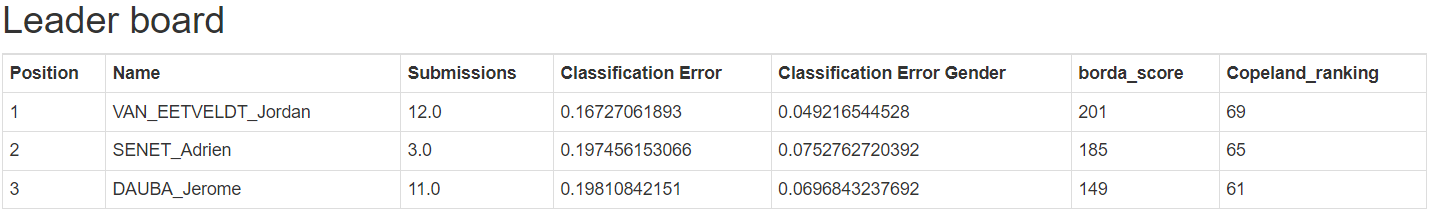

The data set is provided by IDEMIA, a multinational security company with headquaters in France. It consistst of images of faces of different persons with certain characteristics. The task is to train a model able to predict whether certain image possess required chacteristics (encoded by the output labels) or not. There is imbalance between the sample images in the dataset for men and women.

# Notebook Layout :

## Dataset exploration and analysis :
- Dataset import
- Images visualisation and analysis
- Distribution of labels and genres between train and validation set


## Objectif et métriques importantes
- Goal and metrics
- Hypotheses on the label

## Training a CNN
- Dataloader creation and data augmentation
- Naive CNN and stronger pretrained CNN
- Explanability of our model with Captum

## Machine Learning
- Extraction of 68 face landmarks and classification with ML

In [ ]:
#General import :
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import random
from numpy import load
from random import shuffle
from math import *
import glob, os, re

#Visualization :
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-learn utils, metrics :
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Sklearn classification :
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

#Sklearn clustering :
from sklearn.cluster import KMeans

#Dimension reduction :
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Working with images :
import cv2
from PIL import Image

#Model interpretability
!pip install captum
!pip install efficientnet_pytorch

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

#Pytorch specific :
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
!pip install timm
import timm

# Notebook specific :
from tqdm.notebook import tqdm
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
# clear_output()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unrar x '/content/drive/MyDrive/DataChal2/Data_Challenge_IDEMIA.rar'

In [ ]:
## Path to local files :
# path_root = 'C:/Users/Jérôme/Desktop/Data_Challenge_IDEMIA/Data_Challenge_MDI_341/'
# path_to_train = 'C:/Users/Jérôme/Desktop/Data_Challenge_IDEMIA/Data_Challenge_MDI_341/train/'
# path_to_val = 'C:/Users/Jérôme/Desktop/Data_Challenge_IDEMIA/Data_Challenge_MDI_341/validation/'
# path_to_test = 'C:/Users/Jérôme/Desktop/Data_Challenge_IDEMIA/Data_Challenge_MDI_341/test/'
# path_label_train = path_root+'label_train.txt'
# path_label_val = path_root+'label_validation.txt'

## Path to colab files :
path_root = '/content/Data_Challenge_IDEMIA/Data_Challenge_MDI_341/'
path_to_train = path_root + 'train/'
path_to_val = path_root + 'validation/'
path_to_test = path_root + 'test/'
path_label_train = path_root+'label_train.txt'
path_label_val = path_root+'label_validation.txt'

#Train DataFrame :
train_labels = pd.read_csv(path_label_train, sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames = os.listdir(path_to_train)
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
train_filenames = pd.DataFrame(filenames, columns = ['filenames'])
df_train = pd.concat([train_filenames, train_labels], axis=1)

# Validation DataFrame :
val_labels = pd.read_csv(path_label_val, sep = ' ', header = None, names = ['label', 'genre'], dtype=int)
filenames2 = os.listdir(path_to_val)
filenames2.sort(key=lambda f: int(re.sub('\D', '', f)))
val_filenames = pd.DataFrame(filenames2, columns = ['filenames'])
df_val = pd.concat([val_filenames, val_labels], axis=1)

# Test dataframe :
filenames3 = os.listdir(path_to_test)
filenames3.sort(key=lambda f: int(re.sub('\D', '', f)))
df_test = pd.DataFrame(filenames3, columns = ['filenames'])
df_test['label'] = -1

#Train dataframe just for women 0 :
df_train_women = df_train.loc[df_train['genre']==0]
#Train dataframe just for men 1 :
df_train_men = df_train.loc[df_train['genre']==1]

#Val dataframe just for women 0 :
df_val_women = df_val.loc[df_val['genre']==0]
#Val dataframe just for men 1 :
df_val_men = df_val.loc[df_val['genre']==1]

df_train

,filenames,label,genre
0,000000.jpg,0,0
1,000001.jpg,1,0
2,000002.jpg,1,0
3,000003.jpg,0,1
4,000004.jpg,1,1
...,...,...,...
149978,149978.jpg,0,1
149979,149979.jpg,0,0
149980,149980.jpg,0,0
149981,149981.jpg,0,0


In [ ]:
df_val

,filenames,label,genre
0,000000.jpg,1,0
1,000001.jpg,0,1
2,000002.jpg,1,0
3,000003.jpg,1,0
4,000004.jpg,0,1
...,...,...,...
24991,024991.jpg,1,1
24992,024992.jpg,1,0
24993,024993.jpg,0,0
24994,024994.jpg,1,0


In [ ]:
df_test

,filenames,label
0,000000.jpg,-1
1,000001.jpg,-1
2,000002.jpg,-1
3,000003.jpg,-1
4,000004.jpg,-1
...,...,...
27591,027591.jpg,-1
27592,027592.jpg,-1
27593,027593.jpg,-1
27594,027594.jpg,-1


# 1- Data exploration and analysis :

**Genre repartition on train & validation set :**

Genre repartition on the: 



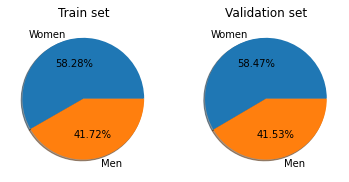

In [ ]:
genre_rate_train = df_train['genre'].value_counts()/len(df_train)
genre_rate_val = df_val['genre'].value_counts()/len(df_val)
genre_list = ["Women", "Men"]

print("Genre repartition on the: \n")
plt.figure()
plt.subplot(1,2,1)
plt.title("Train set")
plt.pie(genre_rate_train, shadow=True, labels = genre_list,autopct='%1.2f%%')
plt.subplot(1,2,2)
plt.title("Validation set")
plt.pie(genre_rate_val, shadow=True, labels = genre_list,autopct='%1.2f%%')
plt.show()

Because we have the same genre distribution, we can conclude that concerning the genre (male / female), the validation set is representative of the train set.

**Unknown characteristics / labels repartition on train & validation set :**

Labels repartition on the: 



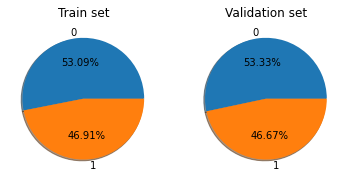

In [ ]:
label_rate_train = df_train['label'].value_counts()/len(df_train)
label_rate_val = df_val['label'].value_counts()/len(df_val)
labels_list = ["0", "1"]

print("Labels repartition on the: \n")
plt.figure()
plt.subplot(1,2,1)
plt.title("Train set")
plt.pie(label_rate_train, shadow=True, labels = labels_list,autopct='%1.2f%%')
plt.subplot(1,2,2)
plt.title("Validation set")
plt.pie(label_rate_val, shadow=True, labels = labels_list,autopct='%1.2f%%')
plt.show()

For the labels, we also observe an identical distribution between train and validation set. Therefore, we conclude that the validation set is very representative of the train set.

Moreover, this unknown label does not seem to affect more women that men : the label is surely not something discriminative between the two genres.

**Other images details :**

In [ ]:
print('total training images:', len(os.listdir(path_to_train)))
print('total validation images:', len(os.listdir(path_to_val)))
print('total test images:', len(os.listdir(path_to_test)))

total training images: 149983
total validation images: 24996
total test images: 27596


Image shape : (80, 80, 3)


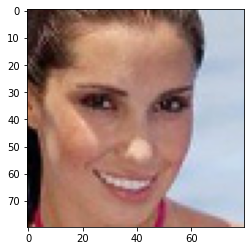

In [ ]:
image = Image.open(os.path.join(path_to_train, df_train['filenames'].sample().item()))
print("Image shape :",np.array(image).shape)
plt.imshow(image)
plt.show()

**Let's visualize some random images of label 0 then label 1 to (maybe) get some insights :**

Random images with label 0


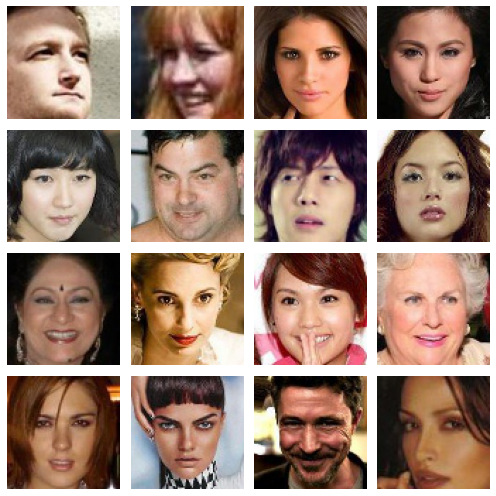


 Random images with label 1


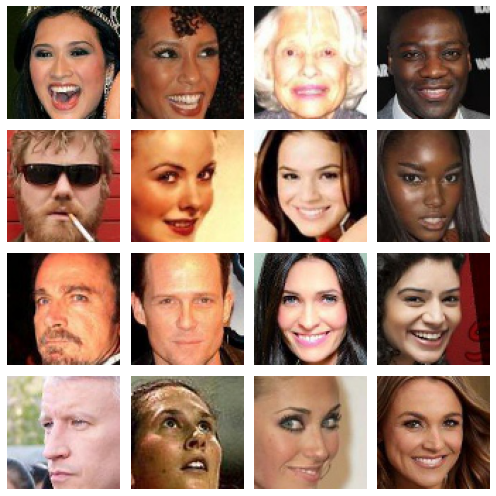

In [ ]:
"""**Visualization of some random images :**"""

## Visualizing label 0 :
print("Random images with label 0")
plt.figure(figsize=(7,7))
for i in range(16):
    image = Image.open(os.path.join(path_to_train, df_train.loc[df_train['label']==0, 'filenames'].sample().item()))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
plt.show()


## Visualizing label 1:
print("\n Random images with label 1")
plt.figure(figsize=(7,7))
for i in range(16):
    image = Image.open(os.path.join(path_to_train, df_train.loc[df_train['label']==1, 'filenames'].sample().item()))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
plt.show()

With naked eye, we can't find a feature that enables us to classify easily images between label 0 and 1. **Let's build a CNN that will perform better !**

# 2- Goal and important metrics :

**Goal :** classify accurately images with the (unknown) label
**Secondary goal :** undestand what the label represents

**Metrics :** accuracy, or difference between predicted and true labels. We will train our model on the train set, and test it and the validation set : we'll try to maximise the validation set score.

# 3- DataLoader and CNN architectures

In [ ]:
class Idemia_Dataset(Dataset):
    """Idemia face classification Dataset."""
    def __init__(self, root_dir, train_file, transform):
        self.root_dir = root_dir
        self.df_train = train_file
        self.transform = transform
        self.classes = list(self.df_train['label'].unique())

    def __getitem__(self, idx):
        """Return (image, target) after resize and preprocessing."""
        img = os.path.join(self.root_dir, self.df_train.iloc[idx, 0])
        
        X = Image.open(img)
        y = self.class_to_index(self.df_train.iloc[idx,1])
        X = np.array(X)/255.
        X = torch.tensor(X)
        X = X.float()
        X = X.permute(2, 0, 1)

        if self.transform:
            X = self.transform(X)
        
        y = torch.tensor([y])
        return X, y
    
    def class_to_index(self, class_name):
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    def index_to_class(self, class_index):
        """Returns the class of a given index."""
        return self.classes[class_index]
    
    def class_to_label(self, class_name):
        """Returns the label of a given class"""
        return self.dic_classes[class_name]
    
    def get_class_count(self):
        """Return a list of label occurences"""
        cls_count = dict(self.df_train.label.value_counts())
        return cls_count
    
    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.df_train)

To make a more robust model, I decided to add some Data augmentation : at each epoch (step) of training, the model will see different images thus making it more robust to new images.

Transformations that are done for Data augmentation :
- Random Horizontal flipping and rotations
- Appliying random color modifications (brightness, contrast, saturation)


In [ ]:
#Passing to grayscale ? If yes and it works : label is no lipstick etc...

transform = torch.nn.Sequential(
    transforms.Resize((80,80)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.05),
    transforms.RandomApply(torch.nn.ModuleList([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)]), p=0.1))

transform_test = torch.nn.Sequential(
    transforms.Resize((80,80)))

dataset_train = Idemia_Dataset(root_dir=path_to_train, train_file=df_train, transform=transform)
dataset_val = Idemia_Dataset(root_dir=path_to_val, train_file=df_val, transform=transform_test)
dataset_test = Idemia_Dataset(root_dir=path_to_test, train_file=df_test, transform=transform_test)

# dataset_train_men = Idemia_Dataset(root_dir=path_to_train, train_file=df_train_men, transform=transform)
# dataset_train_women = Idemia_Dataset(root_dir=path_to_train, train_file=df_train_women, transform=transform)

# dataset_val_men = Idemia_Dataset(root_dir=path_to_val, train_file=df_val_men, transform=transform_test)
# dataset_val_women = Idemia_Dataset(root_dir=path_to_val, train_file=df_val_women, transform=transform_test)

## Class for training and evaluating the model

In this class, we first split our training data into a training set and a validation set (10% of the training set).

Then we can **train** our model, and also **evaluate** it by displaying random images and the model prediction.


Furthermore, I wrote a function in this class that enables us to **understand  what the model have learned and highlight the pixels that led to a certain prediction** (with the library **Captum**). Indeed, Captum can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

In [ ]:
class Train_Eval_Model():
    """Train and / or evaluate a choosen model."""
    def __init__(self, net, dataset_train, dataset_val, dataset_test, batch_size):
        self.dataset_train = dataset_train
        self.dataset_val = dataset_val
        self.dataset_test = dataset_test
        
        self.batch_size = batch_size
        self.random_seed= 42
        
        # Average Mean and Std for all images in the training dataset, for all 3 layers
        self.mean1 = 0.
        self.mean2 = 0.
        self.mean3 = 0.
        self.std1 = 1
        self.std2 = 1
        self.std3 = 1
        
        dataset_size = len(self.dataset_train)
        indices = list(range(dataset_size))

        # Creating Dataloaders :
        self.train_loader = torch.utils.data.DataLoader(self.dataset_train, self.batch_size, shuffle=True, drop_last=True, num_workers=4)
        self.validation_loader = torch.utils.data.DataLoader(self.dataset_val, self.batch_size, num_workers=4)
        self.test_loader = torch.utils.data.DataLoader(self.dataset_test, self.batch_size, num_workers=4)
        
        #Loading the model with cuda or cpu
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = net.to(self.device)
        print("GPU :",torch.cuda.get_device_name(0), "activated")
        torch.cuda.empty_cache()
        print("Init OK")
        
   
    def denormalize(self,tensor):
        """Denormalize tensor to display true image"""
        tensor[0,:,:] = tensor[0,:,:]*self.std1 + self.mean1
        tensor[1,:,:] = tensor[1,:,:]*self.std2 + self.mean2
        tensor[2,:,:] = tensor[2,:,:]*self.std3 + self.mean3
        return tensor
    
    def acc_score(self, y_pred,y_true):
        y_pred = y_pred.cpu().detach()
        y_true = y_true.cpu().detach()
        score = accuracy_score(y_true,y_pred)
        return score
    
    
    def train(self, epochs:int, lr:float, loader_str:str):
        torch.cuda.empty_cache()
        self.net.to(self.device)
        
        #Criterion and optimizer :
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=lr)
        #optimizer = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)
        
        #Training :
        self.net.train()
        liste_loss = []
        accuracy_train_mean = []
        accuracy_val_mean_liste = []
        
        for epoch in tqdm(range(epochs)):
            running_loss = 0.0
            i = 0
            if loader_str == 'val':
              loader = self.validation_loader
            else:
              loader = self.train_loader

            for data_train in tqdm(loader):
                # For the training set :
                inputs_train, labels_train = data_train
                labels_train = labels_train.to(torch.float32)
                inputs_train, labels_train = inputs_train.to(self.device), labels_train.to(self.device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs_train = self.net(inputs_train)
                outputs_train = outputs_train.float()
                outputs_train.to(self.device)

                loss = criterion(outputs_train, labels_train)
                loss.to(self.device)
                loss.backward()
                optimizer.step()
                

                # print statistics
                running_loss += loss.item()

                if i%50==49:
                  print("loss: %.3f" % running_loss)
                  running_loss = 0.0

                if i % 500 == 499:    # print every 20 batches
                    with torch.no_grad():
                        outputs_train = torch.round(outputs_train)
                        accuracy_train = self.acc_score(outputs_train,labels_train)
                        accuracy_train_mean.append(accuracy_train)
                        
                        # On itère sur tout le validation set (data augmented)
                        accuracy_val_liste = []
                        for data_val in tqdm(self.validation_loader) :
                            
                            #For the validation set :
                            inputs_val, labels_val = data_val
                            labels_val = labels_val.to(torch.float32)
                            inputs_val, labels_val = inputs_val.to(self.device), labels_val.to(self.device)
                            
                            outputs_val = self.net(inputs_val)
                            outputs_val = outputs_val.float()
                            outputs_val = torch.round(outputs_val)

                            accuracy_val = self.acc_score(outputs_val,labels_val)
                            if accuracy_val < 0.5 :
                                accuracy_val = 1- accuracy_val
                                
                            accuracy_val_liste.append(accuracy_val)
                        
                        accuracy_val_mean = np.mean(accuracy_val_liste)
                        accuracy_val_mean_liste.append(accuracy_val_mean)
                    

                    print('[%d, %5d] loss: %.3f , ACC train: %.3f , ACC val: %.3f' %
                          (epoch + 1, i + 1, running_loss, accuracy_train, accuracy_val_mean))
                    liste_loss.append(running_loss)
                    running_loss = 0.0  
                i+=1
        print('Finished Training')
        plt.figure(figsize=(10,7))
        plt.plot(liste_loss, label='Training loss')
        plt.legend()
        plt.title("Training loss")
        plt.show()

        #Plot AUC evolution for Train and Val :
        plt.figure(figsize=(10,7))
        plt.plot(accuracy_train_mean,label='Accuracy train')
        plt.plot(accuracy_val_mean_liste,label='Accuracy val')
        plt.legend()
        plt.show()
        
        
    def save(self, out_name:str):
        torch.save(self.net.state_dict(), out_name)
        print('Model weights successfully saved !')
        
    def load(self, path_load:str):
        self.net.load_state_dict(torch.load(path_load))
        self.net.to(self.device)
        print("Model loaded successfully")
        
    
    def validation_score(self):
        # On itère sur tout le validation set (data augmented)
        accuracy_val_liste = []
        liste_outputs = []
        liste_outputs_raw = []
        with torch.no_grad():
            torch.cuda.empty_cache()
            self.net.eval()
            for data_val in tqdm(self.validation_loader) :

                #For the validation set :
                inputs_val, labels_val = data_val
                labels_val = labels_val.to(torch.float32)
                inputs_val, labels_val = inputs_val.to(self.device), labels_val.to(self.device)

                outputs_val = self.net(inputs_val)
                outputs_val = outputs_val.float()
                outputs_val_raw = outputs_val
                outputs_val = torch.round(outputs_val)
                
                for i,j in zip(outputs_val, outputs_val_raw) :
                    liste_outputs.append(int(i.item()))
                    liste_outputs_raw.append(j.item())


                accuracy_val = self.acc_score(outputs_val,labels_val)
                if accuracy_val < 0.5 :
                    accuracy_val = 1- accuracy_val

                accuracy_val_liste.append(accuracy_val)

            accuracy_val_mean = np.mean(accuracy_val_liste)
            print("Mean Accuracy on validation set:", accuracy_val_mean)
            
            df_val2 = df_val.copy(deep=True)
            df_val2['predicted'] = liste_outputs
            df_val2['predicted_raw'] = liste_outputs_raw
            
            group_by_genre = df_val2.groupby('genre')
            genre_0, genre_1 = [group_by_genre.get_group(x) for x in group_by_genre.groups]

            print('Accuracy_score genre_0: ' , accuracy_score(genre_0['label'], genre_0['predicted']))
            print('Accuracy_score genre_1: ' , accuracy_score(genre_1['label'], genre_1['predicted']))

            return df_val2
        
    
    def show_eval_mosaique(self, loader_str:str):
        """ Show a mosaique of 32 images, display
        their true labels and the associated prediction"""
        self.net.eval()
        liste_auc = []
        if loader_str == 'train':
            loader = self.train_loader
        else :
            loader = self.validation_loader
            
        for i, data in enumerate(loader):
            with torch.no_grad():
                inputs, labels  = data
                labels = labels.to(torch.float32)
                inputs = inputs.to(self.device)

                outputs = self.net(inputs)
                if loader_str == 'train':
                    outputs = torch.round(outputs.float())
                else :
                    outputs = abs(1-torch.round(outputs.float()))
                liste_auc.append(self.acc_score(outputs.cpu(),labels))
            break

        #Displaying the images and their true & predicted labels :
        plt.figure(figsize=(25,50))
        for j, image in enumerate(inputs):
            image = image.cpu()
            image = self.denormalize(image)
            image = np.transpose(image, (1,2,0))
            image = np.array(image)
            plt.subplot(16,4,j+1)
            plt.imshow(image)
            plt.title(f'{int(labels[j].item())}, prediction : {labels[j].item()==outputs[j].item()}',size=13)
            plt.axis('off')
        print("AUC mean on this batch :", np.mean(liste_auc))
        plt.show()
        
        print('\n', "Confusion Matrix:")
        conf_matrix = confusion_matrix(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy(), labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
        disp.plot()

    
    def explain_image(self,image):
        """Understanding how our model works with Captum :
        Captum can estimate which areas of the image are critical 
        for the classifier's decision by occluding them and 
        quantifying how the decision changes.

        We run a sliding window of size 5x5 
        (defined via sliding_window_shapes) with a stride of 4 
        along both image dimensions (a defined via strides)."""
    
        occlusion = Occlusion(self.net)

        attributions_occ = occlusion.attribute(image.unsqueeze(0),
                                           strides = (3, 4, 4),
                                           target=None,
                                           sliding_window_shapes=(3,5, 5),
                                           baselines=0)

        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                          np.uint8(np.transpose(self.denormalize(image.squeeze().detach().cpu())*255., (1,2,0))),
                                          ["original_image", "heat_map"],
                                          ["all", "positive"],
                                          show_colorbar=True,
                                          outlier_perc=1,
                                         cmap='Reds')
        
    def show_eval_explained(self, explain:bool):
        """ Display a random image in the train set 
        and its heatmap with the occlusion method"""
        self.net.eval()

        rand = random.randint(0,len(self.validation_loader))
        inputs, labels = self.train_loader.dataset[rand][0], self.train_loader.dataset[rand][1]
        labels = labels.to(torch.float32)
        inputs_explain = inputs.clone().to(self.device)
        inputs = inputs.unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.net(inputs)
            print("Output probability: %.3f" % (outputs.item()))
            outputs = torch.round(outputs.float())

        #Plotting the results :
        image = inputs.squeeze().detach().cpu()
        image = self.denormalize(image)

        image = np.transpose(image, (1,2,0))
        image = np.array(image)

        plt.imshow(image)
        plt.title(f'{int(labels.item())}, prediction {labels.item()==outputs.item()}', size=15)
        plt.axis('Off')
        plt.show()

        if explain :
            print("Interpreting prediction results. This could take up to 1 long minute...")
            print("Highlighting areas that led to that prediction...")
            self.explain_image(inputs_explain)
            
    def submit_test(self, filename:str):
        # On itère sur tout le test set
        liste_outputs = []
        with torch.no_grad():
            torch.cuda.empty_cache()
            self.net.eval()
            for data in tqdm(self.test_loader) :

                #For the validation set :
                inputs, labels = data
                labels = labels.to(torch.float32)
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.net(inputs)
                outputs = outputs.float()
                outputs = torch.round(outputs)
                
                for i in outputs :
                    liste_outputs.append(int(i.item()))

            
            results=pd.DataFrame(liste_outputs, columns= ['score'])
            results.to_csv(f"{filename}.csv", header = None, index = None)
            
            return liste_outputs

**Defining the Neural Network : First is naive, second is stronger (Densenet), third is even bigger (EfficientNet)**

For the 2 stronger architectures, I decided added dense layers to classify features extracted by the Densenet or EfficientNet.

With a lot of dropout (p=0.4) and thanks to the previous data augmentation, our network will be even stronger.

I also implemented some features to improve the robustness of the newtorks :
- ELU activation instead of ReLU : ELU doesn't have the dying ReLU problem. Also, the function tends to converge cost to zero faster and produces more accurate results(recently read it on a blog). In conclusion, ELU is more of a merger between good features of ReLU & Leaky ReLU.
- Extract the mean and max of the vector of features extracted by the model (Densenet or EfficientNet), and concatenate it to the features vector.

In [ ]:
batch_size = 64

""" Naive CNN, handmade """
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(16384, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
#         print("Après conv", x.shape)
        x = x.view(batch_size, -1)
        print("Après view", x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
#         print("Après fc1", x.shape)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
#         print("Après fc2", x.shape)
        x = self.fc3(x)
        return torch.sigmoid(x)
    
    

    
""" CNN with a pretrained Densenet 169 & dense layers to classify """
class Net2(nn.Module):
    def __init__(self, pretrained):
        super(Net2, self).__init__()
        #self.model = models.densenet169(pretrained=pretrained)
        self.model = models.googlenet(pretrained=True)
        self.linear1 = nn.Linear(1000, 512)
        self.linear2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.3)
        self.elu = nn.ELU()
        self.out = nn.Linear(256,1)
    
    def forward(self, x):
        out = self.model(x)
        batch = out.shape[0]
        max_pool, _ = torch.max(out, 1, keepdim=True)
        avg_pool = torch.mean(out, 1, keepdim=True)

        out = out.view(batch, -1)
        conc = torch.cat((out, max_pool, avg_pool), 1)

        conc = self.linear1(out)
        conc = self.elu(conc)
        conc = self.dropout(conc)
        conc = self.linear2(conc)
        conc = self.elu(conc)

        res = self.out(conc)
        return torch.sigmoid(res)


""" CNN with a pretrained Efficient Net & dense layers to classify """
class Net3(nn.Module):
    def __init__(self, pretrained):
        super(Net3, self).__init__()
        #self.model = models.densenet201(pretrained=pretrained)
        self.model = EfficientNet.from_pretrained('efficientnet-b7')
        self.linear1 = nn.Linear(1000+2, 512)
        self.linear2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.4)
        self.elu = nn.ELU()
        self.out = nn.Linear(256,1)
    
    def forward(self, x):
        out = self.model(x)
        batch = out.shape[0]
        max_pool, _ = torch.max(out, 1, keepdim=True)
        avg_pool = torch.mean(out, 1, keepdim=True)

        out = out.view(batch, -1)
        conc = torch.cat((out, max_pool, avg_pool), 1)

        conc = self.linear1(conc)
        conc = self.elu(conc)
        conc = self.dropout(conc)
        conc = self.linear2(conc)
        conc = self.elu(conc)
        conc = self.dropout(conc)

        res = self.out(conc)
        return torch.sigmoid(res)


# """ CNN with a pretrained Efficient Net B8 & dense layers to classify """
# class Net4(nn.Module):
#     def __init__(self, pretrained):
#         super(Net4, self).__init__()
#         #self.model = models.densenet201(pretrained=pretrained)
#         self.model = EfficientNet.from_pretrained('efficientnet-b8', advprop=True)
#         self.linear1 = nn.Linear(1000+2, 512)
#         self.linear2 = nn.Linear(512, 256)
#         self.dropout = nn.Dropout(0.4)
#         self.elu = nn.ELU()
#         self.out = nn.Linear(256,1)
    
#     def forward(self, x):
#         out = self.model(x)
#         batch = out.shape[0]
#         max_pool, _ = torch.max(out, 1, keepdim=True)
#         avg_pool = torch.mean(out, 1, keepdim=True)

#         out = out.view(batch, -1)
#         conc = torch.cat((out, max_pool, avg_pool), 1)

#         conc = self.linear1(conc)
#         conc = self.elu(conc)
#         conc = self.dropout(conc)
#         conc = self.linear2(conc)
#         conc = self.elu(conc)

#         res = self.out(conc)
#         return torch.sigmoid(res)

In [ ]:
model = Train_Eval_Model(Net3(pretrained=True), dataset_train, dataset_val, dataset_test, batch_size=64)

Loaded pretrained weights for efficientnet-b7
GPU : Tesla P100-PCIE-16GB activated
Init OK


Thanks to the class above, I can save the model weights after training (on my Drive) and then reload them easily :

In [ ]:
model.load("/content/drive/MyDrive/DataChal2/net2_pretrained_78_efficientnetV3.pth")

Model loaded successfully


Here I am displaying what the training of the model looks like, even though the model has already converged thanks to these previously loaded weights.

Each 500 iteration, I test the model on the validation set to get the true model accuracy. If the training loss keeps going down but the validation accuracy goes up, then we can detect overfitting !

loss: 18.080
loss: 17.356
loss: 17.500
loss: 17.909
loss: 17.093
loss: 18.340
loss: 18.787
loss: 17.503
loss: 17.489
loss: 16.987



[1,   500] loss: 0.000 , ACC train: 0.719 , ACC val: 0.823
loss: 17.044
loss: 17.080
loss: 17.595
loss: 17.349
loss: 17.246
loss: 17.615
loss: 18.146
loss: 16.910
loss: 17.548
loss: 18.202



[1,  1000] loss: 0.000 , ACC train: 0.828 , ACC val: 0.825
loss: 17.101
loss: 16.703
loss: 16.825
loss: 17.701
loss: 17.379
loss: 17.734
loss: 17.456
loss: 17.683
loss: 17.232
loss: 17.959



[1,  1500] loss: 0.000 , ACC train: 0.859 , ACC val: 0.825
loss: 18.280
loss: 16.709
loss: 17.134
loss: 17.146
loss: 18.426
loss: 17.394
loss: 17.917
loss: 17.481
loss: 17.598
loss: 17.042



[1,  2000] loss: 0.000 , ACC train: 0.922 , ACC val: 0.825
loss: 16.986
loss: 17.549
loss: 17.793
loss: 18.174
loss: 17.372
loss: 16.994


Finished Training


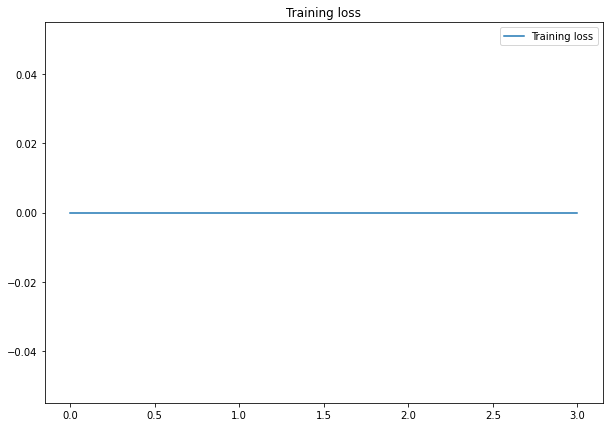

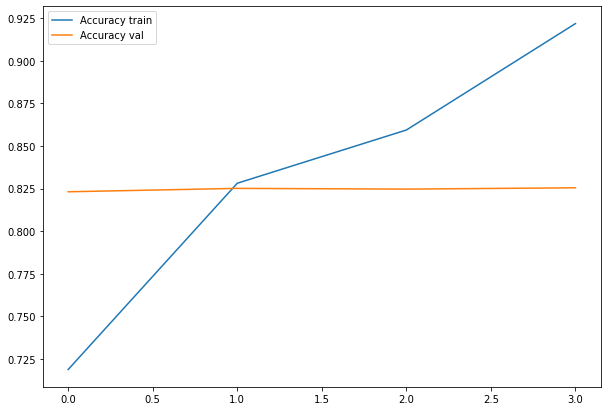

In [ ]:
model.train(epochs=1, lr=1e-5, loader_str='train')

In [ ]:
model.save("net3_pretrained_efficientnetB7_V5.pth")

Model weights successfully saved !


Then we can evaluate our model on the validation set, and displaying the accuracy scores for the 2 genres :

In [ ]:
df_val2 = model.validation_score()


Mean Accuracy on validation set: 0.8283736501847115
Accuracy_score genre_0:  0.855686328178459
Accuracy_score genre_1:  0.7895395877480255


Plotting repartition density of raw probabilities given by the model for True predictions :

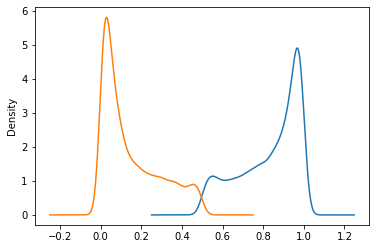

In [ ]:
df_val2.loc[(df_val2['label']==df_val2['predicted']) & (df_val2['label']==1) , 'predicted_raw'].plot.density()
df_val2.loc[(df_val2['label']==df_val2['predicted']) & (df_val2['label']==0) , 'predicted_raw'].plot.density()

Plotting repartition density of raw probabilities given by the model for False predictions :

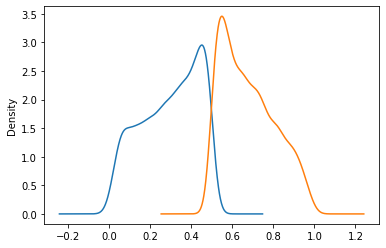

In [ ]:
df_val2.loc[(df_val2['label']!=df_val2['predicted']) & (df_val2['label']==1) , 'predicted_raw'].plot.density()
df_val2.loc[(df_val2['label']!=df_val2['predicted']) & (df_val2['label']==0) , 'predicted_raw'].plot.density()

**For boths graphs, the best threshold appears to be 0.5 : we can't change this value to improve accuracy.**

Let's now see if there's a difference by genre :

In [ ]:
df_val2.loc[(df_val2['label']==df_val2['predicted']) & (df_val2['label']==0) , ['predicted_raw', 'genre']].groupby('genre').mean()

,predicted_raw
genre,
0,0.130655
1,0.173484


In [ ]:
df_val2.loc[(df_val2['label']==df_val2['predicted']) & (df_val2['label']==1) , ['predicted_raw', 'genre']].groupby('genre').mean()

,predicted_raw
genre,
0,0.871095
1,0.750399


We observe that our model have more difficulty to classify men than women --> I tried to train 2 models separately on men and women, but the accuracy didn't improve : there is something inherent in the images that makes it more difficult for men to be classified, but I couldn't understand what !

Then we can display a mosaique (batch) of images and the models prediction :

In [ ]:
# Score on a batch of images (mosaique) from the train or validation set :
model.show_eval_mosaique(loader_str='train')

Output hidden; open in https://colab.research.google.com to view.

Now let us try a different approach to try to understand our classifier. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes with the library Captum : https://captum.ai/

We run a sliding window of size 15x15 with a stride of 8 along both image dimensions. At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch.

**Finally, we can generate a heatmap that highlights the areas of the image that led to that label prediction ! This is very interesting for us, as we have no idea of what are the labels**

Output probability: 0.093


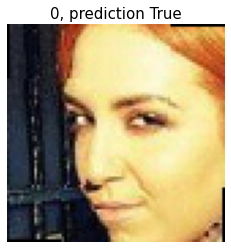

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


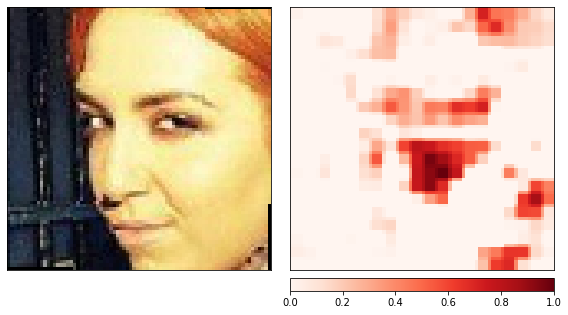

In [ ]:
model.show_eval_explained(explain=True)

Output probability: 0.083


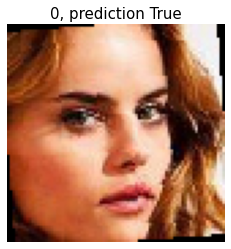

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


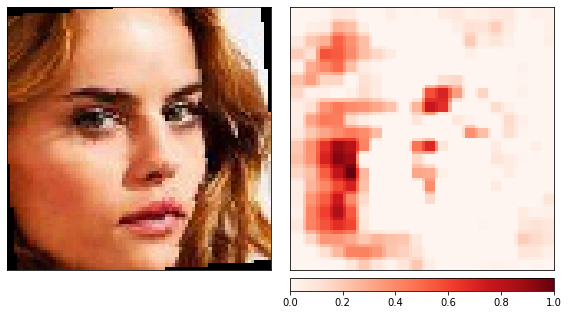

In [ ]:
model.show_eval_explained(explain=True)

Output probability: 0.969


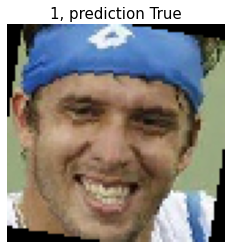

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


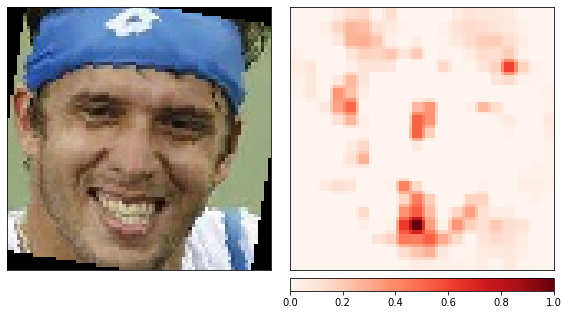

In [ ]:
model.show_eval_explained(explain=True)

Output probability: 0.953


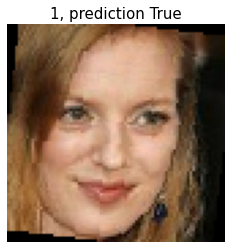

Interpreting prediction results. This could take up to 1 long minute...
Highlighting areas that led to that prediction...


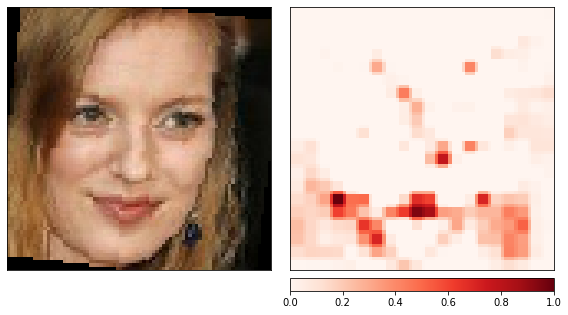

In [ ]:
model.show_eval_explained(explain=True)

Here are other heatmaps, superimposed with photoshop :

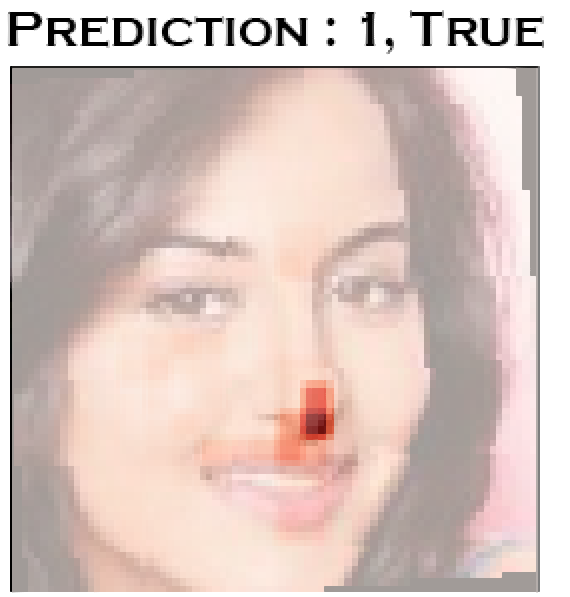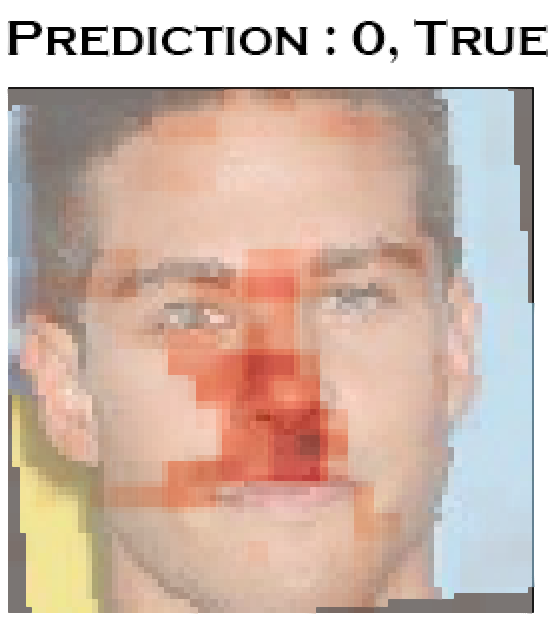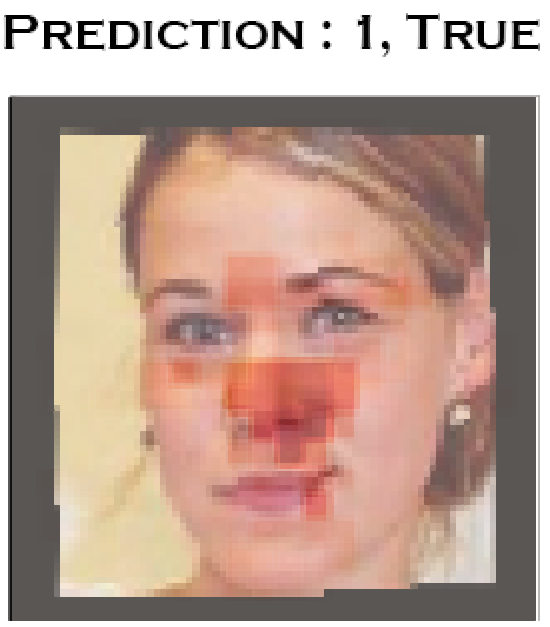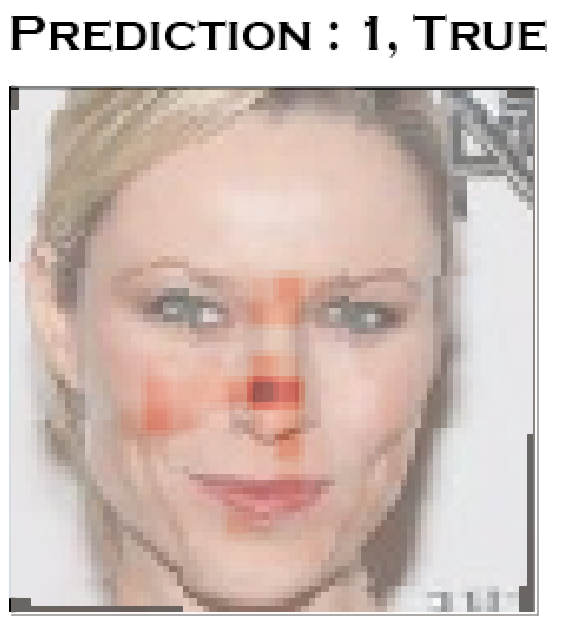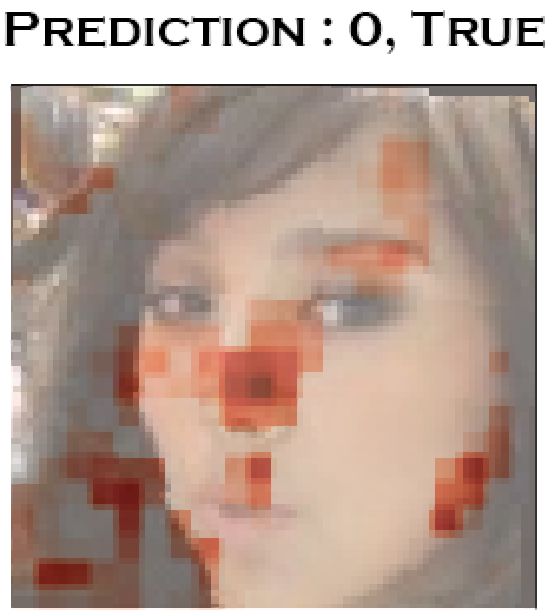

It appears that the main highlighted areas for label 0 and 1 are around the nose and the mouth : the label can then represents the nose width (not confirmed visually), a particular type of nose, or maybe the distance between the nose and the lips.

**Test and submit :**

In [ ]:
model.submit_test("Submission_DL_V9")

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,


After submission, the model with the EfficientNet b7 gave :
- A classification error of 0.198
- A gender error of 0.696
- A borda score of 149
- A copeland ranking of 61

**That led to the 3rd place !**

Than to the occlusion technique, it seems that the unknown label may be a facial feature such as distance between 2 points of the face.

To verify this hypothesis, let's do some ML by extracting 68 important face landmarks for each image, calculating several interesting distances, and try to learn something from it :

In [ ]:
import dlib
import bz2

zipfile = bz2.BZ2File("/content/Data_Challenge_IDEMIA/shape_predictor_68_face_landmarks.dat.bz2")
shape_predictor = zipfile.read()
open("/content/Data_Challenge_IDEMIA/shape_predictor_68_face_landmarks.dat", 'wb').write(shape_predictor) # write a uncompressed file

face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("/content/Data_Challenge_IDEMIA/shape_predictor_68_face_landmarks.dat")

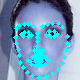

In [ ]:
# Test on the random face :
img = Image.open(os.path.join(path_to_train, df_train['filenames'].sample().item()))
img = np.array(img)

faces = face_detector(img, 1)
landmark_tuple = []
for k, d in enumerate(faces):
  landmarks = landmark_detector(img, d)
  for n in range(0, 68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmark_tuple.append((x, y))
    cv2.circle(img, (x, y), 2, (255, 255, 0), -1)
cv2_imshow(img)

For each image of a Dataloader, let's extract its landmarks and calculate 14 distances (ex: distance between tip of the nose and upper lips) :

In [ ]:
training_loader = torch.utils.data.DataLoader(dataset_train, batch_size=512, drop_last=False, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dataset_val, batch_size=512, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=512, drop_last=False, num_workers=4)

def extract_landmarks(dataloader):
  landmark_d1 = []
  landmark_d2 = []
  landmark_d3 = []
  landmark_d4 = []
  landmark_d5 = []
  landmark_d6 = []
  landmark_d7 = []
  landmark_d8 = []
  landmark_d9 = []
  landmark_d10 = []
  landmark_d11 = []
  landmark_d12 = []
  landmark_d13 = []
  landmark_d14 = []

  for image_batch, labels in tqdm(dataloader):
    for image in image_batch :
      image = np.transpose(np.array(image*255), (1,2,0))
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      image = np.uint8(image)

      faces = face_detector(image, 1)
      try:
        a = faces[0]
      except:
        landmark_d1.append(0)
        landmark_d2.append(0)
        landmark_d3.append(0)
        landmark_d4.append(0)
        landmark_d5.append(0)
        landmark_d6.append(0)
        landmark_d7.append(0)
        landmark_d8.append(0)
        landmark_d9.append(0)
        landmark_d10.append(0)
        landmark_d11.append(0)
        landmark_d12.append(0)
        landmark_d13.append(0)
        landmark_d14.append(0)

      mult_faces = 0
      for k, d in enumerate(faces):
        if k > 0:
          mult_faces +=1
          print(mult_faces)
          break          

        landmarks = landmark_detector(image, d)

        # 1- Top nose to tip of nose :
        top_nose = 28
        tip_nose = 34
        d1 = np.sqrt((landmarks.part(top_nose).x - landmarks.part(tip_nose).x)**2 + (landmarks.part(top_nose).y - landmarks.part(tip_nose).y)**2)

        # 2-left chick to top lip
        left_chick = 3
        top_lip = 52
        d2 = np.sqrt((landmarks.part(left_chick).x - landmarks.part(top_lip).x)**2 + (landmarks.part(left_chick).y - landmarks.part(top_lip).y)**2)

        # 3-left eye - right eye distance
        left_eye = 40
        right_eye = 43
        d3 = np.sqrt((landmarks.part(left_eye).x - landmarks.part(right_eye).x)**2 + (landmarks.part(left_eye).y - landmarks.part(right_eye).y)**2)

        # 4-Tip nose & top lip
        d4 = np.sqrt((landmarks.part(tip_nose).x - landmarks.part(top_lip).x)**2 + (landmarks.part(tip_nose).y - landmarks.part(top_lip).y)**2)

        # 5-Top lip - bottom lip
        bottom_lip = 58
        d5 = np.sqrt((landmarks.part(top_lip).x - landmarks.part(bottom_lip).x)**2 + (landmarks.part(top_lip).y - landmarks.part(bottom_lip).y)**2)

        # 6-Left mouth - right mouth
        left_mouth = 49
        right_mouth = 55
        d6 = np.sqrt((landmarks.part(left_mouth).x - landmarks.part(right_mouth).x)**2 + (landmarks.part(left_mouth).y - landmarks.part(right_mouth).y)**2)

        # 7-Chin & top nose
        chin = 9
        d7 = np.sqrt((landmarks.part(top_nose).x - landmarks.part(chin).x)**2 + (landmarks.part(top_nose).y - landmarks.part(chin).y)**2)

        # 8- tip nose - bottom lip
        d8 = np.sqrt((landmarks.part(tip_nose).x - landmarks.part(bottom_lip).x)**2 + (landmarks.part(tip_nose).y - landmarks.part(bottom_lip).y)**2)

        #9- tip nose - upper right cheeck
        upper_right_chick = 17
        upper_left_chick = 1
        upper_left_chick2 = 2
        left_nose = 32
        d9 = np.sqrt((landmarks.part(tip_nose).x - landmarks.part(upper_right_chick).x)**2 + (landmarks.part(tip_nose).y - landmarks.part(upper_right_chick).y)**2)

        # 10- upper left cheek2 - left nose
        d10 = np.sqrt((landmarks.part(upper_left_chick2).x - landmarks.part(left_nose).x)**2 + (landmarks.part(upper_left_chick2).y - landmarks.part(left_nose).y)**2)

        # 11-right_eyebrow - nose tip
        right_eyebrow = 25
        left_eyebrow = 20
        d11 = np.sqrt((landmarks.part(tip_nose).x - landmarks.part(right_eyebrow).x)**2 + (landmarks.part(tip_nose).y - landmarks.part(right_eyebrow).y)**2)

        # 12-right - left eyebrow
        d12 = np.sqrt((landmarks.part(left_eyebrow).x - landmarks.part(right_eyebrow).x)**2 + (landmarks.part(left_eyebrow).y - landmarks.part(right_eyebrow).y)**2)

        # 13- upper right cheek - right eye
        d13 = np.sqrt((landmarks.part(upper_right_chick).x - landmarks.part(right_eye).x)**2 + (landmarks.part(upper_right_chick).y - landmarks.part(right_eye).y)**2)

        # 14- tip nose - left mouth
        d14 = np.sqrt((landmarks.part(tip_nose).x - landmarks.part(left_mouth).x)**2 + (landmarks.part(tip_nose).y - landmarks.part(left_mouth).y)**2)

        landmark_d1.append(d1)
        landmark_d2.append(d2)
        landmark_d3.append(d3)
        landmark_d4.append(d4)
        landmark_d5.append(d5)
        landmark_d6.append(d6)
        landmark_d7.append(d7)
        landmark_d8.append(d8)
        landmark_d9.append(d9)
        landmark_d10.append(d10)
        landmark_d11.append(d11)
        landmark_d12.append(d12)
        landmark_d13.append(d13)
        landmark_d14.append(d14)

  return landmark_d1, landmark_d2, landmark_d3, landmark_d4, landmark_d5, landmark_d6, landmark_d7,landmark_d8, landmark_d9, landmark_d10, landmark_d11, landmark_d12, landmark_d13, landmark_d14

As the extraction is long (25min) for the training set, let's first show the results by extracting landmarks from the validation set :

In [ ]:
landmark_d1, landmark_d2, landmark_d3, landmark_d4, landmark_d5, landmark_d6, landmark_d7, landmark_d8, landmark_d9, landmark_d10, landmark_d11, landmark_d12, landmark_d13, landmark_d14 = extract_landmarks(validation_loader)

Now let's create a DataFrame containing all the calculated features / distances :

In [ ]:
df_train_Landmarks = df_val.copy(deep=True)

df_train_Landmarks['d1'] = landmark_d1
df_train_Landmarks['d2'] = landmark_d2
df_train_Landmarks['d3'] = landmark_d3
df_train_Landmarks['d4'] = landmark_d4
df_train_Landmarks['d5'] = landmark_d5
df_train_Landmarks['d6'] = landmark_d6
df_train_Landmarks['d7'] = landmark_d7
df_train_Landmarks['d8'] = landmark_d1
df_train_Landmarks['d9'] = landmark_d2
df_train_Landmarks['d10'] = landmark_d3
df_train_Landmarks['d11'] = landmark_d4
df_train_Landmarks['d12'] = landmark_d5
df_train_Landmarks['d13'] = landmark_d6
df_train_Landmarks['d14'] = landmark_d7

df_train_Landmarks2 = df_train_Landmarks.loc[df_train_Landmarks['d1']!=0]

y = df_train_Landmarks2['label']
X = df_train_Landmarks2[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14']]

Let's now test several algorith of Machine Learning, such as Linear regression or Gradient Boosting :

In [ ]:
clf1 = LinearRegression().fit(X, y)
clf2 = HistGradientBoostingClassifier(learning_rate=1.0).fit(X, y)

print("Simple Linear Regression:",clf1.score(X, y))
print("Histogram based Gradient Boosting:",clf2.score(X, y))

Simple Linear Regression: 0.13030256900152293
Histogram based Gradient Boosting: 0.8432945235015092


These results seem pretty good, and they are the same when learning on the train set and testing on the validation set. But while submitting with the test images, the accuracy suddenly dropped at 64%.

I spent most of my time on deep learning, but it would have been interesting to dig a little more with ML to understand why the test score is so low and how to improve it.

This ML part seems to validate the hypothesis of an unknown features which might be correlated with some distances between facial landmarks, but I'm not sure